# Definitions


# akiyama

### def function

In [ ]:
import os
import pdb
import torch
os.chdir('/home/kobayashilab/raid10ssd/akiyamay/BPM_github/')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch
from torch.fft import fft2, ifft2, fftfreq
from tqdm.auto import trange
from enum import StrEnum

import base64
from IPython.display import HTML, display
import math


class DiffractionMode(StrEnum):
    PARAXIAL = "paraxial"
    """θ<~ 10°; 計算が安定"""
    WIDEANGLE = "wideangle"
    """θ<~ 25°; dxとdyが小さすぎると屈折率虚数で高周波成分が壊れる"""

def bpm_propagation(
    E0: torch.Tensor,  # torch.Tensor[torch.complex128]
    z_steps: int,
    dx: float,
    dy: float,
    dz: float,
    wavelength: float,
    n0: float,
    n_xy: torch.Tensor,  # torch.Tensor[torch.float64]
    iz_snap: torch.Tensor,  # torch.Tensor[torch.int64]
    diffraction_mode: DiffractionMode = DiffractionMode.PARAXIAL,
) -> torch.Tensor:  # torch.Tensor[torch.complex128]
    """
    近軸近似に基づくスプリットステップBPMによるビーム伝搬を行う。

    Parameters
    ----------
    E0 : torch.Tensor[torch.complex128]
        z=0 の (x,y) 平面上の複素振幅分布 (Nx, Ny)
    z_steps : int
        z方向のステップ数
    dx, dy : float
        x, y, z 方向の空間サンプリング間隔 [m]
    wavelength : float
        真空中の波長 [m]
    n0 : float
        基準屈折率（全体の平均的な屈折率など）
    n_xy : torch.Tensor[np.float64]
        (x,y) 平面上の屈折率分布 (Nx, Ny)
        ここでは z方向に均一(=変化なし)と仮定している。
    iz_snap: torch.Tensor[np.int64]
        Eのスナップショットをとるステップ番号のリスト (0 <= iz <= z_steps)

    Returns
    -------
    E_snap : torch.Tensor[np.complex128]
        z = iz_snap * dz の平面での複素振幅分布 (*iz_snap.shape, Nx, Ny)
    """
    # --- 基本定数等の準備 ---
    # 真空中の波数 k0 = 2π / λ
    k0 = 2.0 * torch.pi / wavelength

    # --- 入力場をコピーして伝搬の計算に使う ---
    E = E0.clone()

    Nx, Ny = E.shape

    # 周波数領域の格子ベクトル (kx, ky)
    # fftfreq(N, d=Δx) は -1/(2Δx) 〜 +1/(2Δx) の範囲で周波数を生成
    kx: torch.Tensor = 2.0 * torch.pi * fftfreq(Nx, d=dx, device=E.device)
    ky: torch.Tensor = 2.0 * torch.pi * fftfreq(Ny, d=dy, device=E.device)
    # メッシュグリッド (KX, KY) (Nx, Ny)
    KX, KY = torch.meshgrid(kx, ky, indexing="ij")

    match diffraction_mode:
        case DiffractionMode.PARAXIAL:
            # --- フーリエ領域での回折項 (パラキシアル近似) ---
            #   H = exp( -i * (kx^2 + ky^2) / (2 * k0 * n0) * dz )
            #   これが各 zステップごとの回折演算に対応する
            H: torch.Tensor = torch.exp(-1j * (KX**2 + KY**2) / (2.0 * k0 * n0) * dz)
        case DiffractionMode.WIDEANGLE:
            # --- "広角" (semi-paraxial) 回折演算子 (Fourierドメイン)
            #     kz(kx, ky) = sqrt((k0*n0)^2 - (kx^2 + ky^2))
            #     伝搬演算子 = exp( -i [ kz - k0 n0 ] dz )
            kz: torch.Tensor = torch.sqrt((k0 * n0) ** 2 - (KX**2 + KY**2))
            H: torch.Tensor = torch.exp(1j * (kz - k0 * n0) * dz)
        case _:
            raise NotImplementedError

    # --- 屈折率による位相変調 (z方向に均一: n_xy は常に同じ) ---
    #   φ = k0 * (n_xy - n0) * dz
    #   z方向に均一なら毎ステップ同じ位相を掛けるだけ
    phase_term: torch.Tensor = torch.exp(1j * k0 * (n_xy - n0) * dz)

    E_snap = torch.zeros((*iz_snap.shape, *E.shape), dtype=E.dtype, device=E.device)
    E_snap[torch.nonzero(iz_snap == 0)] = E

    # --- スプリットステップループ ---
    for iz in trange(z_steps):
        # 1) 回折項 (Fourierドメインで位相を掛ける)
        E_f = fft2(E)
        E_f *= H
        E = ifft2(E_f)

        # 2) 屈折率分布による位相変化を実空間で掛ける
        E *= phase_term

        # 保存
        E_snap[torch.nonzero(iz_snap == iz + 1)] = E

    return E_snap

def get_xz_on_triangle(i: int,
                       divisions: int,
                       base_center: tuple,
                       height: float,
                       base_length: float) -> tuple:
    """XZ平面内の二等辺三角形の等辺上に等間隔に並ぶ点を取得する関数。
    
    Parameters
    ----------
    i : int
        取得したい点のインデックス (0 ≤ i < 2*divisions)
    divisions : int
        一つの等辺を何分割するか。各等辺上に分割数だけ点が並びます。
    base_center : tuple
        底辺（x軸平行）の中心位置。(x, z)の形で渡します。
    height : float
        底辺から頂点までの高さ（物理長さ）。Z方向の移動時はこの値をfで割って使用します。
    base_length : float
        底辺の長さ（物理長さ）。
    
    Returns
    -------
    tuple
        書き込みを行うべきX,Z座標を返します。
    """
    # 底辺の両端
    half_base = base_length / 2
    left_x, left_z   = base_center[0] - half_base, base_center[1]
    right_x, right_z = base_center[0] + half_base, base_center[1]

    # 頂点（Z方向はスケール補正）
    apex_x = base_center[0]
    apex_z = base_center[1] + height

    total_pts = divisions * 2
    assert 0 <= i < total_pts, "i must be in [0, 2*divisions)"

    # i < divisions のときは「左辺 (左底辺→頂点)」、
    # それ以外は「右辺 (右底辺→頂点)」を扱う
    if i < divisions:
        # 左辺の j = 1 .. divisions
        j = i + 1
        frac = j / divisions
        x = left_x + frac * half_base
        z = left_z + frac * height
    else:
        # 右辺の j = 1 .. divisions
        j = (i - divisions) + 1
        frac = j / divisions
        x = right_x - frac * half_base
        z = right_z + frac * height

    return (x, z)



def all_in_triangle(divisions: int,
                       base_center: tuple,
                       height: float,
                       base_length: float):
    wrposi=[]
    for k in range(2*divisions-1):
        wrposi.append(get_xz_on_triangle(k,
                           divisions,
                           base_center,
                           height,
                           base_length))
    return wrposi


def get_xz_on_circle(i: int,
                       divisions: int,
                       base_center: tuple,
                       radius: float,
                       ) -> tuple:
    """XZ平面内の二等辺三角形の等辺上に等間隔に並ぶ点を取得する関数。
    
    Parameters
    ----------
    i : int
        取得したい点のインデックス (0 ≤ i < 2*divisions)
    divisions : int
        一つの等辺を何分割するか。各等辺上に分割数だけ点が並びます。
    base_center : tuple
        円の中心位置。(x, z)の形で渡します。
    radius : float
    
    Returns
    -------
    tuple
        書き込みを行うべきX,Z座標を返します。
    """
    interval= np.pi*2 / divisions 
    assert 0 <= i < divisions, "i must be in [0, 2*divisions)"
    x= base_center[0] + radius* np.cos(interval* i)
    z= base_center[1] + radius* np.sin(interval* i)

    return (x, z)


def all_in_circle(divisions: int,
                       base_center: tuple,
                       radius: float):
    wrposi=[]
    for k in range(divisions):
        wrposi.append(get_xz_on_circle(k,
                           divisions,
                           base_center,
                           radius))
    return wrposi

#####################################################
# 1. 書き込みを行った座標に屈折率変化を与える関数
#####################################################

def ndown(
    n_xy: torch.Tensor,
    wxc: float,
    wyc: float,
    bwx: float,
    bwy: float,
    na: float,
    X: torch.Tensor,
    Y: torch.Tensor
) -> torch.Tensor:
    """
    ガウス分布で屈折率変化を付与する(屈折率を減少/増加させる)plot_y_eq_0(
    n_xy : 屈折率分布
    wxc, wyc : 変化中心座標
    bwx, bwy : ガウス分布の幅
    na       : ピーク値 (マイナスの値なら屈折率減少)
    X, Y     : メッシュグリッド
    """
    # 例: 屈折率が na だけ増減するガウス分布を加算
    #     ガウスの形状は exp(-(2*(X-wxc)^2 / bwx^2 + 2*(Y-wyc)^2 / bwy^2))
    # ここでは n_xy += ... として書き込みを行う
    gaus = na * torch.exp(
        -(
            2.0 * (X - wxc) ** 2 / (bwx**2)
            + 2.0 * (Y - wyc) ** 2 / (bwy**2)
        )
    )
    gaus=gaus.to(dtype=torch.complex128).to(device)
    n_xy += gaus
    return n_xy

import torch
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

def plot_y_eq_0(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    z_snap: torch.Tensor,
    dx: float,
    dy: float,
    dz: float,
    ax: Axes = None,
    x_range: tuple = (-250, 250),
    cmap: str = "cet_rainbow4",
    vmin: float = None,
    vmax: float = None,
    k: float = 0
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    # y, z_snap, I_snap はすべて CUDA 上にある前提
    # y.searchsorted を使って最も近いインデックスを取得し，Python の int に
    iyc = torch.searchsorted(y, k)

    # shape: [len(z_snap), Nx] -> 転置後 [Nx, len(z_snap)]
    I_xz = I_snap[:, iyc, :].cpu().numpy().T

    # 物理座標範囲を µm 単位で設定
    z_min, z_max = (z_snap[0].item() - dz / 2)*1e6, (z_snap[-1].item() + dz / 2)*1e6
    x_min, x_max = (x[0].item() - dx / 2)*1e6, (x[-1].item() + dx / 2)*1e6

    # vmin, vmax が未指定ならデータに応じて設定
    if vmin is None:
        vmin = min(0, I_xz.min())
    if vmax is None:
        vmax = max(1, I_xz.max())

    im = ax.imshow(
        I_xz,
        cmap=cmap,
        origin="lower",
        aspect="auto",
        extent=(z_min, z_max, x_min, x_max),
        vmin=vmin,
        vmax=vmax
    )
    ax.set_ylabel("x (µm)")
    ax.set_xlabel("z (µm)")
    ax.set_ylim(x_range)
    ax.set_title(f"Intensity at y={k} µm (iy={iyc})")
    return im



def plot_x_eq_0(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    z_snap: torch.Tensor,
    dx: float,
    dy: float,
    dz: float,
    ax: Axes = None,
    y_range: tuple = (-500, 500),
    cmap: str = "cet_rainbow4",
    vmin: float = None,
    vmax: float = None
):
    """
    x=0付近の断面 (y-z面) の強度分布を imshow で表示する。
    
    Parameters
    ----------
    I_snap : torch.Tensor
        [len(z_snap), Ny, Nx] 形状の強度データ
    x, y : torch.Tensor
        x, y座標配列 (1次元)
    z_snap : torch.Tensor
        zステップ配列
    dx, dy, dz : float
        サンプリング間隔
    cmap : str
        カラーマップ
    ax : matplotlib.axes.Axes
        描画先のAxes
    y_range : tuple
        y方向の表示範囲 (µm)
    vmin, vmax : float
        カラースケールの最小値・最大値
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    # y, z_snap, I_snap はすべて CUDA 上にある前提
    # 比較用のスカラー k を y と同じデバイス・dtype で作成
    k_dev = 0
    # y.searchsorted を使って最も近いインデックスを取得し，Python の int に
    ixc = int(torch.searchsorted(x, k_dev))

    # shape: [len(z_snap), Nx] -> 転置後 [Nx, len(z_snap)]
    I_yz = I_snap[:, :, ixc].cpu().numpy().T

    # 物理座標範囲を µm 単位で設定
    z_min, z_max = (z_snap[0].item() - dz / 2)*1e6, (z_snap[-1].item() + dz / 2)*1e6
    y_min, y_max = (y[0].item() - dy / 2)*1e6, (y[-1].item() + dy / 2)*1e6

    # vmin, vmax が未指定ならデータに応じて設定
    if vmin is None:
        vmin = min(0, I_yz.min())
    if vmax is None:
        vmax = max(1, I_yz.max())

    im = ax.imshow(
        I_yz,
        cmap=cmap,
        origin="lower",
        aspect="auto",
        extent=(z_min, z_max, y_min, y_max),
        vmin=vmin,
        vmax=vmax
    )
    ax.set_ylabel("y (µm)")
    ax.set_xlabel("z (µm)")
    ax.set_ylim(y_range)
    ax.set_title(f"Intensity at x=0 µm (ix={ixc})")

    return im


def plot_z_slice(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    idx_z: int,
    dx: float,
    dy: float,
    cmap: str = "cet_rainbow4",
    ax: Axes = None,
    x_range: tuple = None,
    y_range: tuple = None,
    title: str = None,
    vmin: float = None,
    vmax: float = None
):
    """
    指定したzインデックスの断面 (x-y平面) をプロットする。
    
    Parameters
    ----------
    I_snap : torch.Tensor
        形状: [len(z_snap), Ny, Nx] の強度データ
    x, y : torch.Tensor
        x, y座標配列
    idx_z : int
        何番目のzスナップを可視化するか
    dx, dy : float
        サンプリング間隔
    cmap : str
        カラーマップ
    ax : matplotlib.axes.Axes
        描画先のAxes (指定がなければ新規作成)
    x_range, y_range : tuple
        x, yそれぞれの表示範囲 (µm単位) (例: (-300,300))
    title : str
        描画する際のタイトル
    vmin, vmax : float
        カラースケールの最小値・最大値
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    I_xy = I_snap[idx_z, :, :].cpu().numpy()

    x_min, x_max = (x[0].item() - dx / 2)*1e6, (x[-1].item() + dx / 2)*1e6
    y_min, y_max = (y[0].item() - dy / 2)*1e6, (y[-1].item() + dy / 2)*1e6

    if vmin is None:
        vmin = 0
    if vmax is None:
        vmax = I_xy.max()

    im = ax.imshow(
        I_xy,
        cmap=cmap,
        origin="lower",
        extent=(x_min, x_max, y_min, y_max),
        vmin=vmin,
        vmax=vmax
    )

    if x_range is not None:
        ax.set_xlim(*x_range)
    if y_range is not None:
        ax.set_ylim(*y_range)
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")

    if title is not None:
        ax.set_title(title)

    return im


import torch
import matplotlib.pyplot as plt
import io
import imageio
import numpy as np
from PIL import Image, ImageSequence

def create_gif_animation(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    dx: float,
    dy: float,
    z_snap: torch.Tensor,
    gif_filename: str,
    fps: int = 10,
    cmap: str = "cet_rainbow4",
    x_range: tuple = None,
    y_range: tuple = None,
    bunkatsu=10
):
    """
    I_snap 内の全z断面 (あるいは一部) を順番にプロットしてGIFアニメを作成。

    Parameters
    ----------
    I_snap : (nZ, Ny, Nx) の強度分布
    x, y   : 1D座標配列
    dx, dy : [m] サンプリング間隔
    z_snap : [nZ] zステップ配列 (m)
    gif_filename : 出力GIFのファイル名
    fps : GIFのフレームレート
    cmap : カラーマップ
    x_range, y_range : 表示範囲 (µm単位)
    """
    import io
    import imageio

    images = []
    nZ = I_snap.shape[0]

    # vmin, vmax を全断面で合わせたい場合は先に求めておく
    # (必要なければ各断面で自動的に決めてもOK)
    global_min = float(I_snap.min())
    global_max = float(I_snap.max())
    # あるいは 0 ~ max などに固定
    vmin, vmax = 0, global_max

    for idx_z in range(nZ):
        if idx_z% bunkatsu==0:
            z_mm = z_snap[idx_z].item() * 1e3  # mm単位
            title_str = f"z = {z_mm:.3f} mm"

            # Figureを作って描画
            fig, ax = plt.subplots(figsize=(4,3))
            plot_z_slice(
                I_snap,
                x, y,
                idx_z,
                dx, dy,
                cmap=cmap,
                x_range=x_range,
                y_range=y_range,
                title=title_str,
                vmin=vmin,
                vmax=vmax,
                ax=ax
            )
            
            # カラーバーを追加したい場合
            # imshowの戻り値を受け取って colorbar へ
            # ただし plot_z_slice() から返した im を受け取るようにするなど工夫が必要
            # ここでは簡単のため割愛

            # 図を一時的にメモリ上へ保存
            buf = io.BytesIO()
            plt.savefig(buf, format="png", dpi=100)
            plt.close(fig)  # 使い終わったFigureは閉じる

            buf.seek(0)
            # 画像として読み込み
            img = imageio.v2.imread(buf)
            images.append(img)

    # GIFで保存
    imageio.mimsave(gif_filename, images, fps=fps, loop=0)
    print(f"GIF saved to {gif_filename}")


def make_multibeam(y_center=0,
                   wavel=793e-9,          # ← 正しい波長[m]
                   beam_waist=105e-6,
                   NA=0.15):
    top_hat_mask = ((X**2 + (Y - y_center)**2) < beam_waist**2).to(torch.float64)

    # 一様ランダム位相
    random_phase = 2 * math.pi * torch.rand_like(X, dtype=torch.float64)
    E_random = top_hat_mask * torch.exp(1j * random_phase)

    # FFT → フィルタ
    E_fft = torch.fft.fftn(E_random)
    Nx, Ny = X.shape
    dx = dy = wavel
    kx = 2*math.pi * torch.fft.fftfreq(Nx, d=dx, dtype=torch.float64)
    ky = 2*math.pi * torch.fft.fftfreq(Ny, d=dy, dtype=torch.float64)
    KX, KY = torch.meshgrid(kx, ky, indexing='ij')
    k_radius = torch.sqrt(KX**2 + KY**2)
    k0      = 2*math.pi / wavel
    k_cut   = k0 * NA
    filter_mask = (k_radius < k_cut)
    E_fft_filtered = E_fft*filter_mask

    # 逆FFT
    E_filtered = torch.fft.ifftn(E_fft_filtered)

    # パワー正規化（ゼロ除算回避）
    power_before = (E_random.abs()**2).sum()
    power_after  = (E_filtered.abs()**2).sum()
    if power_after > 0:
        scale = torch.sqrt(power_before / power_after)
        E_filtered = E_filtered * scale
    # else: すべてカットされて 0 のまま

    return E_filtered.to(dtype=torch.complex128).to(device)

In [4]:
import torch
import gc

def show_cuda_tensor_memory():
    total_memory = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                size_bytes = obj.element_size() * obj.nelement()
                total_memory += size_bytes
                print(f"Tensor: {type(obj)}, shape: {tuple(obj.shape)}, size: {size_bytes / 1024:.2f} KB")
        except Exception as e:
            pass
    print(f"Total CUDA tensor memory: {total_memory / 1024 / 1024:.2f} MB")

show_cuda_tensor_memory()


Total CUDA tensor memory: 0.00 MB


/home/kobayashilab/.pyenv/versions/3.13.1/lib/python3.13/site-packages/torch/__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


In [5]:
torch.cuda.empty_cache()

### class def

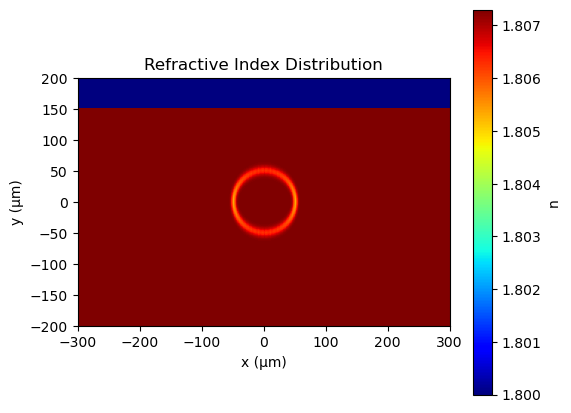

  0%|          | 0/1000 [00:00<?, ?it/s]

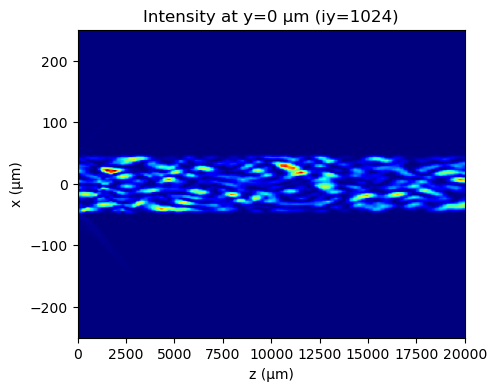

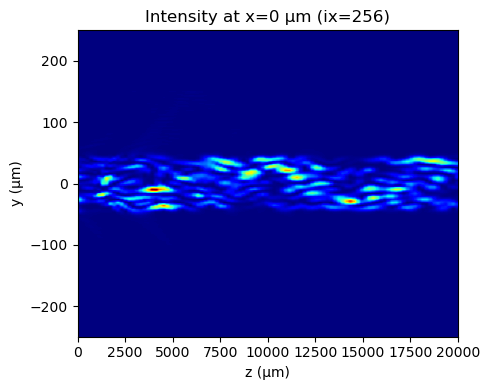

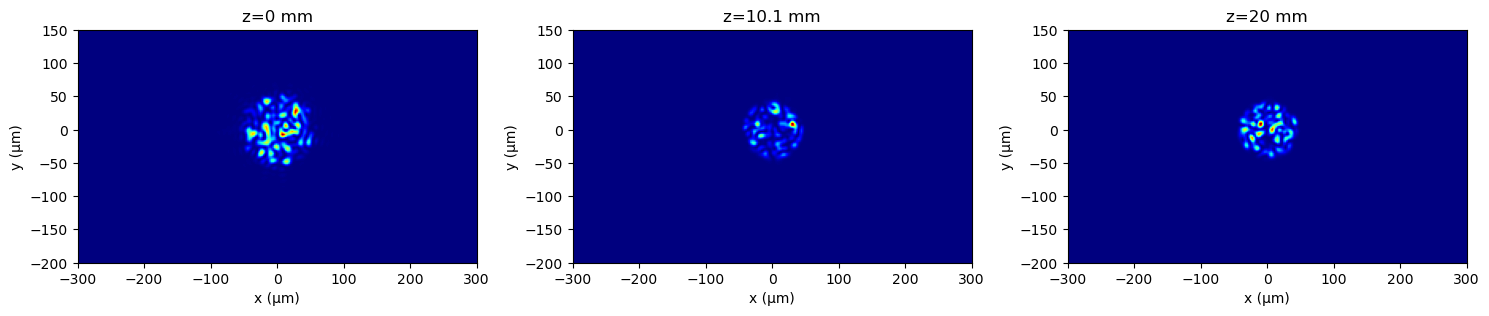

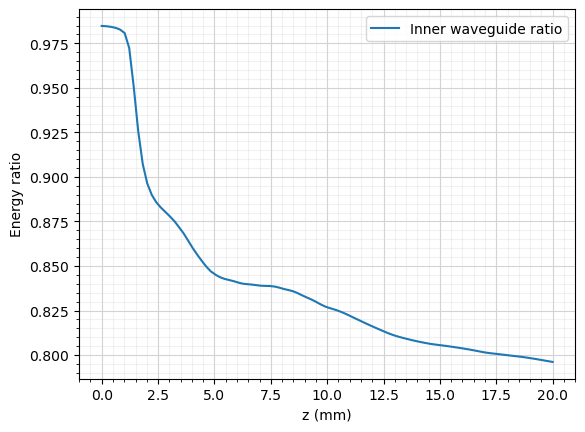

ValueError: 'cet_rainbow4' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

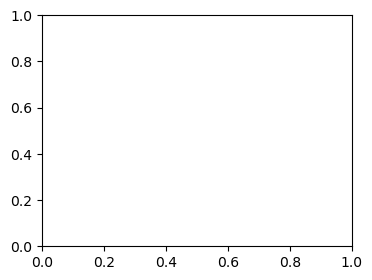

In [4]:
import os
import pdb
import torch
# os.chdir('/home/kobayashilab/raid10ssd/akiyamay/BPM_github/')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch
from torch.fft import fft2, ifft2, fftfreq
from tqdm.auto import trange
from enum import StrEnum

import base64
from IPython.display import HTML, display
import math
import matplotlib.pyplot as plt
from matplotlib.axes import Axes


class DiffractionMode(StrEnum):
    PARAXIAL = "paraxial"
    """θ<~ 10°; 計算が安定"""
    WIDEANGLE = "wideangle"
    """θ<~ 25°; dxとdyが小さすぎると屈折率虚数で高周波成分が壊れる"""

def bpm_propagation(
    E0: torch.Tensor,  # torch.Tensor[torch.complex128]
    z_steps: int,
    dx: float,
    dy: float,
    dz: float,
    wavelength: float,
    n0: float,
    n_xy: torch.Tensor,  # torch.Tensor[torch.float64]
    iz_snap: torch.Tensor,  # torch.Tensor[torch.int64]
    diffraction_mode: DiffractionMode = DiffractionMode.PARAXIAL,
) -> torch.Tensor:  # torch.Tensor[torch.complex128]
    """
    近軸近似に基づくスプリットステップBPMによるビーム伝搬を行う。

    Parameters
    ----------
    E0 : torch.Tensor[torch.complex128]
        z=0 の (x,y) 平面上の複素振幅分布 (Nx, Ny)
    z_steps : int
        z方向のステップ数
    dx, dy : float
        x, y, z 方向の空間サンプリング間隔 [m]
    wavelength : float
        真空中の波長 [m]
    n0 : float
        基準屈折率（全体の平均的な屈折率など）
    n_xy : torch.Tensor[np.float64]
        (x,y) 平面上の屈折率分布 (Nx, Ny)
        ここでは z方向に均一(=変化なし)と仮定している。
    iz_snap: torch.Tensor[np.int64]
        Eのスナップショットをとるステップ番号のリスト (0 <= iz <= z_steps)

    Returns
    -------
    E_snap : torch.Tensor[np.complex128]
        z = iz_snap * dz の平面での複素振幅分布 (*iz_snap.shape, Nx, Ny)
    """
    # --- 基本定数等の準備 ---
    # 真空中の波数 k0 = 2π / λ
    k0 = 2.0 * torch.pi / wavelength

    # --- 入力場をコピーして伝搬の計算に使う ---
    E = E0.clone()

    Nx, Ny = E.shape

    # 周波数領域の格子ベクトル (kx, ky)
    # fftfreq(N, d=Δx) は -1/(2Δx) 〜 +1/(2Δx) の範囲で周波数を生成
    kx: torch.Tensor = 2.0 * torch.pi * fftfreq(Nx, d=dx, device=E.device)
    ky: torch.Tensor = 2.0 * torch.pi * fftfreq(Ny, d=dy, device=E.device)
    # メッシュグリッド (KX, KY) (Nx, Ny)
    KX, KY = torch.meshgrid(kx, ky, indexing="ij")

    match diffraction_mode:
        case DiffractionMode.PARAXIAL:
            # --- フーリエ領域での回折項 (パラキシアル近似) ---
            #   H = exp( -i * (kx^2 + ky^2) / (2 * k0 * n0) * dz )
            #   これが各 zステップごとの回折演算に対応する
            H: torch.Tensor = torch.exp(-1j * (KX**2 + KY**2) / (2.0 * k0 * n0) * dz)
        case DiffractionMode.WIDEANGLE:
            # --- "広角" (semi-paraxial) 回折演算子 (Fourierドメイン)
            #     kz(kx, ky) = sqrt((k0*n0)^2 - (kx^2 + ky^2))
            #     伝搬演算子 = exp( -i [ kz - k0 n0 ] dz )
            kz: torch.Tensor = torch.sqrt((k0 * n0) ** 2 - (KX**2 + KY**2))
            H: torch.Tensor = torch.exp(1j * (kz - k0 * n0) * dz)
        case _:
            raise NotImplementedError

    # --- 屈折率による位相変調 (z方向に均一: n_xy は常に同じ) ---
    #   φ = k0 * (n_xy - n0) * dz
    #   z方向に均一なら毎ステップ同じ位相を掛けるだけ
    phase_term: torch.Tensor = torch.exp(1j * k0 * (n_xy - n0) * dz)

    E_snap = torch.zeros((*iz_snap.shape, *E.shape), dtype=E.dtype, device=E.device)
    E_snap[torch.nonzero(iz_snap == 0)] = E

    # --- スプリットステップループ ---
    for iz in trange(z_steps):
        # 1) 回折項 (Fourierドメインで位相を掛ける)
        E_f = fft2(E)
        E_f *= H
        E = ifft2(E_f)

        # 2) 屈折率分布による位相変化を実空間で掛ける
        E *= phase_term

        # 保存
        E_snap[torch.nonzero(iz_snap == iz + 1)] = E

    return E_snap

def get_xz_on_triangle(i: int,
                       divisions: int,
                       base_center: tuple,
                       height: float,
                       base_length: float) -> tuple:
    """XZ平面内の二等辺三角形の等辺上に等間隔に並ぶ点を取得する関数。
    
    Parameters
    ----------
    i : int
        取得したい点のインデックス (0 ≤ i < 2*divisions)
    divisions : int
        一つの等辺を何分割するか。各等辺上に分割数だけ点が並びます。
    base_center : tuple
        底辺（x軸平行）の中心位置。(x, z)の形で渡します。
    height : float
        底辺から頂点までの高さ（物理長さ）。Z方向の移動時はこの値をfで割って使用します。
    base_length : float
        底辺の長さ（物理長さ）。
    
    Returns
    -------
    tuple
        書き込みを行うべきX,Z座標を返します。
    """
    # 底辺の両端
    half_base = base_length / 2
    left_x, left_z   = base_center[0] - half_base, base_center[1]
    right_x, right_z = base_center[0] + half_base, base_center[1]

    # 頂点（Z方向はスケール補正）
    apex_x = base_center[0]
    apex_z = base_center[1] + height

    total_pts = divisions * 2
    assert 0 <= i < total_pts, "i must be in [0, 2*divisions)"

    # i < divisions のときは「左辺 (左底辺→頂点)」、
    # それ以外は「右辺 (右底辺→頂点)」を扱う
    if i < divisions:
        # 左辺の j = 1 .. divisions
        j = i + 1
        frac = j / divisions
        x = left_x + frac * half_base
        z = left_z + frac * height
    else:
        # 右辺の j = 1 .. divisions
        j = (i - divisions) + 1
        frac = j / divisions
        x = right_x - frac * half_base
        z = right_z + frac * height

    return (x, z)



def all_in_triangle(divisions: int,
                       base_center: tuple,
                       height: float,
                       base_length: float):
    wrposi=[]
    for k in range(2*divisions-1):
        wrposi.append(get_xz_on_triangle(k,
                           divisions,
                           base_center,
                           height,
                           base_length))
    return wrposi


def get_xz_on_circle(i: int,
                       divisions: int,
                       base_center: tuple,
                       radius: float,
                       ) -> tuple:
    """XZ平面内の二等辺三角形の等辺上に等間隔に並ぶ点を取得する関数。
    
    Parameters
    ----------
    i : int
        取得したい点のインデックス (0 ≤ i < 2*divisions)
    divisions : int
        一つの等辺を何分割するか。各等辺上に分割数だけ点が並びます。
    base_center : tuple
        円の中心位置。(x, z)の形で渡します。
    radius : float
    
    Returns
    -------
    tuple
        書き込みを行うべきX,Z座標を返します。
    """
    interval= np.pi*2 / divisions 
    assert 0 <= i < divisions, "i must be in [0, 2*divisions)"
    x= base_center[0] + radius* np.cos(interval* i)
    z= base_center[1] + radius* np.sin(interval* i)

    return (x, z)


def all_in_circle(divisions: int,
                       base_center: tuple,
                       radius: float):
    wrposi=[]
    for k in range(divisions):
        wrposi.append(get_xz_on_circle(k,
                           divisions,
                           base_center,
                           radius))
    return wrposi

#####################################################
# 1. 書き込みを行った座標に屈折率変化を与える関数
#####################################################

def ndown(
    n_xy: torch.Tensor,
    wxc: float,
    wyc: float,
    bwx: float,
    bwy: float,
    na: float,
    X: torch.Tensor,
    Y: torch.Tensor
) -> torch.Tensor:
    """
    ガウス分布で屈折率変化を付与する(屈折率を減少/増加させる)plot_y_eq_0(
    n_xy : 屈折率分布
    wxc, wyc : 変化中心座標
    bwx, bwy : ガウス分布の幅
    na       : ピーク値 (マイナスの値なら屈折率減少)
    X, Y     : メッシュグリッド
    """
    # 例: 屈折率が na だけ増減するガウス分布を加算
    #     ガウスの形状は exp(-(2*(X-wxc)^2 / bwx^2 + 2*(Y-wyc)^2 / bwy^2))
    # ここでは n_xy += ... として書き込みを行う
    gaus = na * torch.exp(
        -(
            2.0 * (X - wxc) ** 2 / (bwx**2)
            + 2.0 * (Y - wyc) ** 2 / (bwy**2)
        )
    )
    gaus=gaus.to(dtype=torch.complex128).to(device)
    n_xy += gaus
    return n_xy

def plot_y_eq_0(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    z_snap: torch.Tensor,
    dx: float,
    dy: float,
    dz: float,
    ax: Axes = None,
    x_range: tuple = (-250, 250),
    cmap: str = "cet_rainbow4",
    vmin: float = None,
    vmax: float = None,
    k: float = 0
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    # y, z_snap, I_snap はすべて CUDA 上にある前提
    # y.searchsorted を使って最も近いインデックスを取得し，Python の int に
    iyc = torch.searchsorted(y, k)

    # shape: [len(z_snap), Nx] -> 転置後 [Nx, len(z_snap)]
    I_xz = I_snap[:, iyc, :].cpu().numpy().T

    # 物理座標範囲を µm 単位で設定
    z_min, z_max = (z_snap[0].item() - dz / 2)*1e6, (z_snap[-1].item() + dz / 2)*1e6
    x_min, x_max = (x[0].item() - dx / 2)*1e6, (x[-1].item() + dx / 2)*1e6

    # vmin, vmax が未指定ならデータに応じて設定
    if vmin is None:
        vmin = min(0, I_xz.min())
    if vmax is None:
        vmax = max(1, I_xz.max())

    im = ax.imshow(
        I_xz,
        cmap=cmap,
        origin="lower",
        aspect="auto",
        extent=(z_min, z_max, x_min, x_max),
        vmin=vmin,
        vmax=vmax
    )
    ax.set_ylabel("x (µm)")
    ax.set_xlabel("z (µm)")
    ax.set_ylim(x_range)
    ax.set_title(f"Intensity at y={k} µm (iy={iyc})")
    return im



def plot_x_eq_0(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    z_snap: torch.Tensor,
    dx: float,
    dy: float,
    dz: float,
    ax: Axes = None,
    y_range: tuple = (-500, 500),
    cmap: str = "cet_rainbow4",
    vmin: float = None,
    vmax: float = None
):
    """
    x=0付近の断面 (y-z面) の強度分布を imshow で表示する。
    
    Parameters
    ----------
    I_snap : torch.Tensor
        [len(z_snap), Ny, Nx] 形状の強度データ
    x, y : torch.Tensor
        x, y座標配列 (1次元)
    z_snap : torch.Tensor
        zステップ配列
    dx, dy, dz : float
        サンプリング間隔
    cmap : str
        カラーマップ
    ax : matplotlib.axes.Axes
        描画先のAxes
    y_range : tuple
        y方向の表示範囲 (µm)
    vmin, vmax : float
        カラースケールの最小値・最大値
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    # y, z_snap, I_snap はすべて CUDA 上にある前提
    # 比較用のスカラー k を y と同じデバイス・dtype で作成
    k_dev = 0
    # y.searchsorted を使って最も近いインデックスを取得し，Python の int に
    ixc = int(torch.searchsorted(x, k_dev))

    # shape: [len(z_snap), Nx] -> 転置後 [Nx, len(z_snap)]
    I_yz = I_snap[:, :, ixc].cpu().numpy().T

    # 物理座標範囲を µm 単位で設定
    z_min, z_max = (z_snap[0].item() - dz / 2)*1e6, (z_snap[-1].item() + dz / 2)*1e6
    y_min, y_max = (y[0].item() - dy / 2)*1e6, (y[-1].item() + dy / 2)*1e6

    # vmin, vmax が未指定ならデータに応じて設定
    if vmin is None:
        vmin = min(0, I_yz.min())
    if vmax is None:
        vmax = max(1, I_yz.max())

    im = ax.imshow(
        I_yz,
        cmap=cmap,
        origin="lower",
        aspect="auto",
        extent=(z_min, z_max, y_min, y_max),
        vmin=vmin,
        vmax=vmax
    )
    ax.set_ylabel("y (µm)")
    ax.set_xlabel("z (µm)")
    ax.set_ylim(y_range)
    ax.set_title(f"Intensity at x=0 µm (ix={ixc})")

    return im


def plot_z_slice(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    idx_z: int,
    dx: float,
    dy: float,
    cmap: str = "cet_rainbow4",
    ax: Axes = None,
    x_range: tuple = None,
    y_range: tuple = None,
    title: str = None,
    vmin: float = None,
    vmax: float = None
):
    """
    指定したzインデックスの断面 (x-y平面) をプロットする。
    
    Parameters
    ----------
    I_snap : torch.Tensor
        形状: [len(z_snap), Ny, Nx] の強度データ
    x, y : torch.Tensor
        x, y座標配列
    idx_z : int
        何番目のzスナップを可視化するか
    dx, dy : float
        サンプリング間隔
    cmap : str
        カラーマップ
    ax : matplotlib.axes.Axes
        描画先のAxes (指定がなければ新規作成)
    x_range, y_range : tuple
        x, yそれぞれの表示範囲 (µm単位) (例: (-300,300))
    title : str
        描画する際のタイトル
    vmin, vmax : float
        カラースケールの最小値・最大値
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    I_xy = I_snap[idx_z, :, :].cpu().numpy()

    x_min, x_max = (x[0].item() - dx / 2)*1e6, (x[-1].item() + dx / 2)*1e6
    y_min, y_max = (y[0].item() - dy / 2)*1e6, (y[-1].item() + dy / 2)*1e6

    if vmin is None:
        vmin = 0
    if vmax is None:
        vmax = I_xy.max()

    im = ax.imshow(
        I_xy,
        cmap=cmap,
        origin="lower",
        extent=(x_min, x_max, y_min, y_max),
        vmin=vmin,
        vmax=vmax
    )

    if x_range is not None:
        ax.set_xlim(*x_range)
    if y_range is not None:
        ax.set_ylim(*y_range)
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")

    if title is not None:
        ax.set_title(title)

    return im


import torch
import matplotlib.pyplot as plt
import io
import imageio
import numpy as np
from PIL import Image, ImageSequence

def create_gif_animation(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    dx: float,
    dy: float,
    z_snap: torch.Tensor,
    gif_filename: str,
    fps: int = 10,
    cmap: str = "cet_rainbow4",
    x_range: tuple = None,
    y_range: tuple = None,
    bunkatsu=10
):
    """
    I_snap 内の全z断面 (あるいは一部) を順番にプロットしてGIFアニメを作成。

    Parameters
    ----------
    I_snap : (nZ, Ny, Nx) の強度分布
    x, y   : 1D座標配列
    dx, dy : [m] サンプリング間隔
    z_snap : [nZ] zステップ配列 (m)
    gif_filename : 出力GIFのファイル名
    fps : GIFのフレームレート
    cmap : カラーマップ
    x_range, y_range : 表示範囲 (µm単位)
    """
    import io
    import imageio

    images = []
    nZ = I_snap.shape[0]

    # vmin, vmax を全断面で合わせたい場合は先に求めておく
    # (必要なければ各断面で自動的に決めてもOK)
    global_min = float(I_snap.min())
    global_max = float(I_snap.max())
    # あるいは 0 ~ max などに固定
    vmin, vmax = 0, global_max

    for idx_z in range(nZ):
        if idx_z% bunkatsu==0:
            z_mm = z_snap[idx_z].item() * 1e3  # mm単位
            title_str = f"z = {z_mm:.3f} mm"

            # Figureを作って描画
            fig, ax = plt.subplots(figsize=(4,3))
            plot_z_slice(
                I_snap,
                x, y,
                idx_z,
                dx, dy,
                cmap=cmap,
                x_range=x_range,
                y_range=y_range,
                title=title_str,
                vmin=vmin,
                vmax=vmax,
                ax=ax
            )
            
            # カラーバーを追加したい場合
            # imshowの戻り値を受け取って colorbar へ
            # ただし plot_z_slice() から返した im を受け取るようにするなど工夫が必要
            # ここでは簡単のため割愛

            # 図を一時的にメモリ上へ保存
            buf = io.BytesIO()
            plt.savefig(buf, format="png", dpi=100)
            plt.close(fig)  # 使い終わったFigureは閉じる

            buf.seek(0)
            # 画像として読み込み
            img = imageio.v2.imread(buf)
            images.append(img)

    # GIFで保存
    imageio.mimsave(gif_filename, images, fps=fps, loop=0)
    print(f"GIF saved to {gif_filename}")


def make_multibeam(y_center=0,
                   wavel=793e-9,          # ← 正しい波長[m]
                   beam_waist=105e-6,
                   NA=0.15):
    top_hat_mask = ((X**2 + (Y - y_center)**2) < beam_waist**2).to(torch.float64)

    # 一様ランダム位相
    random_phase = 2 * math.pi * torch.rand_like(X, dtype=torch.float64)
    E_random = top_hat_mask * torch.exp(1j * random_phase)

    # FFT → フィルタ
    E_fft = torch.fft.fftn(E_random)
    Nx, Ny = X.shape
    dx = dy = wavel
    kx = 2*math.pi * torch.fft.fftfreq(Nx, d=dx, dtype=torch.float64)
    ky = 2*math.pi * torch.fft.fftfreq(Ny, d=dy, dtype=torch.float64)
    KX, KY = torch.meshgrid(kx, ky, indexing='ij')
    k_radius = torch.sqrt(KX**2 + KY**2)
    k0      = 2*math.pi / wavel
    k_cut   = k0 * NA
    filter_mask = (k_radius < k_cut)
    E_fft_filtered = E_fft*filter_mask

    # 逆FFT
    E_filtered = torch.fft.ifftn(E_fft_filtered)

    # パワー正規化（ゼロ除算回避）
    power_before = (E_random.abs()**2).sum()
    power_after  = (E_filtered.abs()**2).sum()
    if power_after > 0:
        scale = torch.sqrt(power_before / power_after)
        E_filtered = E_filtered * scale
    # else: すべてカットされて 0 のまま

    return E_filtered.to(dtype=torch.complex128).to(device)
import torch
import matplotlib.pyplot as plt
from pathlib import Path



# ─── グローバル定義 ───────────────────────────────────────────
# ① ユーザがいじりたいパラメータ
LX            = 1000e-6   # [m]
LY            = 4000e-6   # [m]
LZ            = 20e-3     # [m]
WAVELENGTH_P  = 793e-9
WAVELENGTH    = 2e-6
N0            = 1.8073
BEAM_DIAM     = 105e-6
P_OR_S        = 'p'
WGr= 100e-6
divisions = 50
d_n= -1e-3

# ② サンプリング間隔（dx,dyは wavelength_p*3 がデフォルト）


dx = WAVELENGTH_P * 3
dy = dx
dz = 20e-6

# グリッド数（LX, LY は既にグローバル定義済み）
NX = 1 << (round(LX/dx) - 1).bit_length()
NY = 1 << (round(LY/dy) - 1).bit_length()

# x, y 座標ベクトル
x = (torch.arange(NX) - NX//2) * dx
y = (torch.arange(NY) - NY//2) * dy
# グローバル X, Y メッシュグリッド
X, Y = torch.meshgrid(x, y, indexing='xy')

func_dic = {'c':all_in_circle, 't':all_in_triangle}
fsign="c"
func1=func_dic[fsign]

MASK_WG = (X**2+ Y**2 < WGr**2)
folder_n= f'{P_OR_S}_{fsign}_dn={d_n}_div={divisions}_WGr={WGr}_waist={BEAM_DIAM/2}'
# ────────────────────────────────────────────────────────────────


class BPMSimulation:
    def __init__(self,
                 LX=LX, LY=LY, LZ=LZ,
                 wavelengthp=WAVELENGTH_P, wavelength=WAVELENGTH,
                 n0=N0, beam_diameter=BEAM_DIAM,
                 p_or_s=P_OR_S, maskWG=MASK_WG,
                 dx=dx, dy=dy, dz=dz,
                 save_cfolder='save_folder',
                 device=device):
        # 1) インスタンス変数にセット
        self.LX = LX
        self.LY = LY
        self.LZ = LZ
        self.wavelengthp = wavelengthp
        self.wavelength = wavelength
        self.n0 = n0
        self.beam_diameter = beam_diameter
        self.p_or_s = p_or_s
        self.maskWG = maskWG
        self.mag= beam_diameter/ 105e-6
        self.NA = 0.15 / self.mag

        # 2) dx, dy, dz もそのまま
        self.dx = dx
        self.dy = dy
        self.dz = dz

        # 3) グリッド数はグローバル計算結果を使う（必要なら再計算OK）
        self.Nx = NX
        self.Ny = NY
        self.Nz = round(self.LZ / self.dz)

        # 4) x, y, X, Y はグローバル定義をデバイス転送して再利用
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.x      = x.to(self.device)
        self.y      = y.to(self.device)
        self.X      = X.to(self.device)
        self.Y      = Y.to(self.device)

        # 5) 出力フォルダ等
        self.save_folder = Path.cwd() / save_cfolder
        self.save_folder.mkdir(exist_ok=True, parents=True)

        # 基準屈折率分布 n_xy (複素数型)
        self.n_xy = n0 * torch.ones_like(X, dtype=torch.complex128)
        self.n_xy= self.n_xy.to(device)
        

    def apply_gain(self, fgain= 8.2):
        """
        fgain= 4.1e20/cm3 * 2e-20cm2 * 1
        """
        mask_g= self.maskWG

        # 消衰係数の設定
        self.n_xy[mask_g] += -1j * fgain * self.wavelength /(4*math.pi)

    def DLW(self, delta_n, func, bwx =5e-6, bwy=10e-6, **keys):
        """
        導波路の場所を決定する関数とその引数から，屈折率変化を描画
        """
        

        waveguide_posis = func(**keys)
        # waveguide_params から ndown を適用
        for (wxc, wyc) in waveguide_posis:
            self.n_xy = ndown(self.n_xy, wxc, wyc, bwx, bwy, delta_n, self.X, self.Y)
        
        if self.p_or_s == 's':
            self.apply_gain()

    def set_air_region(self, air_up=150e-6, air_down=-1850e-6, n_air=1.0):
        """
        y座標が指定領域を超える部分を空気とみなし屈折率を n_air に。
        注意: self.n_xy.shape=[Nx, Ny] か [Ny, Nx] でマスクの書き方が異なる。
        """
        # ここでは [Nx, Ny] なので、Y.shape=[Nx, Ny]
        # 例: Y[i,j] が y座標
        mask_air = (self.Y < air_down) | (self.Y > air_up)
        self.n_xy[mask_air] = n_air

    def create_initial_field(self, y_center=0, NA=0.15 , beam_waist=105e-6 ):
        """
        初期電場 E0 を作成して返す。
        """
        NA=self.NA 
        beam_waist=(self.beam_diameter/2)
        wavel=self.wavelengthp

        if self.p_or_s=='p':
            E0 = make_multibeam(y_center=y_center, wavel=wavel, beam_waist=beam_waist, NA=NA)
        else:
            E0 = torch.exp(-(X**2 + (Y-y_center)**2) / (beam_waist**2)).to(dtype=torch.complex128).to(device)
        return E0

    def plot_refractive_index(self, x_range=(-300, 300), y_range=(-200, 200),
                              vmin=1.0, vmax=None):
        """
        屈折率分布 self.n_xy を可視化。
        x,y(um) -> 画像表示
        """
        fig, ax = plt.subplots(figsize=(6,5))
        x_um = self.x.cpu().numpy() * 1e6
        y_um = self.y.cpu().numpy() * 1e6

        # self.n_xy.shape=[Nx, Ny] -> 転置が必要 (imshow は [row, col] = [Ny, Nx])
        nplot = self.n_xy.real.detach().cpu().numpy()  # transpose

        extent = (x_um[0], x_um[-1], y_um[0], y_um[-1])
        im = ax.imshow(nplot, origin='lower', extent=extent, cmap='jet')
        if vmin is not None:
            im.set_clim(vmin, vmax)
        ax.set_xlabel("x (µm)")
        ax.set_ylabel("y (µm)")
        ax.set_title("Refractive Index Distribution")
        cbar = fig.colorbar(im, ax=ax, label='n')
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        plt.show()

    def run_bpm(self,
                E0,
                snap_shots=100,
                diffraction_mode=DiffractionMode.PARAXIAL):
        """
        BPM を実行し、指定したスナップショット数の電場分布を返す。
        """
        iz_snap = torch.linspace(0, self.Nz, min(snap_shots, self.Nz+1)).round().to(dtype=torch.int64)
        z_snap = self.dz * iz_snap
        wavel= self.wavelength if self.p_or_s == 's' else self.wavelengthp
        # bpm_propagation の呼び出し (要カスタム実装)
        E_snap = bpm_propagation(
            E0,
            self.Nz,
            self.dx,
            self.dy,
            self.dz,
            wavel,
            self.n0,
            self.n_xy,
            iz_snap,
            diffraction_mode=diffraction_mode,
        )
        return E_snap.cpu(), iz_snap, z_snap

    def plot_field_slices(self, E_snap, iz_snap, z_snap,
                          x_slice_range=(-250,250), y_slice_range=(-250,250),
                          xy_plot_zindex_list=None):
        """
        結果 E_snap から、y=0, x=0 の断面と、z=一定面の x-y プロファイルを
        それぞれプロット
        """
        # I_snap.shape = [num_snap, Ny, Nx] (想定)
        I_snap = torch.abs(E_snap)**2
        plot_y_eq_0(I_snap, self.x, self.y, z_snap, self.dx, self.dy, self.dz,
                    ax=None, x_range=x_slice_range, cmap="jet")
        plot_x_eq_0(I_snap, self.x, self.y, z_snap, self.dx, self.dy, self.dz,
                    ax=None, y_range=y_slice_range, cmap="jet")
        plt.tight_layout()
        plt.show()

        # z=0, 中間, 終端などの x-y プロファイル
        if xy_plot_zindex_list is None:
            # サンプル: 3点
            xy_plot_zindex_list = [0, len(iz_snap)//2, len(iz_snap)-1]

        fig, axr = plt.subplots(1, len(xy_plot_zindex_list), figsize=(5*len(xy_plot_zindex_list), 3))
        for i, idx_z in enumerate(xy_plot_zindex_list):
            z_m = iz_snap[idx_z].item() * self.dz
            title_str = f"z={z_m*1e3:.3g} mm"
            plot_z_slice(I_snap, self.x, self.y, idx_z, self.dx, self.dy,
                         ax=axr[i],
                         x_range=(-300, 300),
                         y_range=(-200, 150),
                         cmap="jet",
                         title=title_str)
        plt.tight_layout()
        plt.show()

    def calc_energy(self, E_snap):
        """
        指定された mask (True/False) 部分のエネルギーを計算し、
        全エネルギーに対する割合を返す。
        """
        mask= self.maskWG
        I_snap = torch.abs(E_snap)**2
        # 総エネルギー
        energy_total = I_snap.sum(dim=(-1, -2))
        # マスク内エネルギー
        I_snap_inner = I_snap.clone()
        I_snap_inner[:, ~mask] = 0.0
        energy_inner = I_snap_inner.sum(dim=(-1, -2))
        return energy_total, energy_inner
    
    def gif_save_show(self, E_snap):
        x_range = (-100, 100)
        y_range = (-100, 100)
        gif_file = f"{self.save_folder}/my_profile_animation.gif"
        I_snap = torch.abs(E_snap)**2
        create_gif_animation(
            I_snap,
            x, y,
            dx, dy,
            z_snap,
            gif_file,
            fps=10,
            cmap="cet_rainbow4",
            x_range=x_range,
            y_range=y_range,
            bunkatsu=1
        )

        with open(gif_file,"rb") as f:
            b64 = base64.b64encode(f.read()).decode()

        html = f'<img src="data:image/gif;base64,{b64}" alt="Beam" />'
        display(HTML(html))


# --------------------------------------------------------------
# 実行例 (メインコードイメージ)
# --------------------------------------------------------------


# -----------------
# 1) シミュレーション設定
# -----------------
sim = BPMSimulation(LX=LX, LY=LY, LZ=LZ,
                 wavelengthp=WAVELENGTH_P, wavelength=WAVELENGTH,
                 n0=N0, beam_diameter=BEAM_DIAM,
                 p_or_s=P_OR_S, maskWG=MASK_WG,
                 dx=dx, dy=dy, dz=dz,
                 save_cfolder=folder_n,
                 device=device)

# -----------------
# 2) 導波路形状の設定 (三角形形状に線を書く例)
# -----------------
sim.DLW(d_n,
    func1,
    bwx=5e-6,
    bwy=10e-6,
    divisions=divisions,
    base_center=(0, 0),
    radius= 50e-6
    )

# 空気領域を設定
sim.set_air_region(air_up=150e-6, air_down=-1850e-6, n_air=1.0)

# -----------------
# 3) 屈折率分布の可視化
# -----------------
sim.plot_refractive_index(x_range=(-300,300), y_range=(-200,200), vmin=1.8)

# -----------------
# 4) 初期ビーム作成 -> BPM 実行
# -----------------
E0 = sim.create_initial_field(y_center=0)
E_snap, iz_snap, z_snap = sim.run_bpm(E0, snap_shots=100)

# -----------------
# 5) 伝搬結果の可視化
# -----------------
sim.plot_field_slices(E_snap, iz_snap, z_snap)

# -----------------
# 6) 導波路内エネルギー計算例
# -----------------
# マスク定義 (例: 三角形領域内)
# shape=[Nx, Ny],  (X, Y) と同じ次元
# 今回は  y > X & y > -X & y < 150e-6 の例
energy_total, energy_inner = sim.calc_energy(E_snap)

# (z軸方向でのエネルギー割合)
ratio_inner = (energy_inner / energy_total[0]).cpu().numpy()
z_vals_mm = (z_snap * 1e3).cpu().numpy()

fig, ax = plt.subplots()
ax.plot(z_vals_mm, ratio_inner, label="Inner waveguide ratio")
ax.set_xlabel("z (mm)")
ax.set_ylabel("Energy ratio")
ax.minorticks_on()
ax.grid(which="both", color="lightgray")
ax.grid(which="minor", alpha=0.3)
ax.legend()
plt.show()

sim.gif_save_show(E_snap)

del E_snap  # 対象の変数
torch.cuda.empty_cache()  # キャッシュもクリア